# PERFORMANCE OF HEDGED CREDIT

AUTHOR: [@sparshsah](https://github.com/sparshsah)

In [85]:
isinstance(type, object)

True

In [84]:
isinstance(pd.DataFrame, object)

True

In [99]:
# utils: ignore

from typing import Optional
import pandas as pd
import numpy as np

SHORT_HORIZON: int = 3
EST_HORIZON: int = 42
DEFAULT_VOL: float = 0.10
DAYCOUNTS = {"BD": 1, "BW": 5, "BM": 21, "BQ": 65, "BY": 261}


def get_r(px: pd.Series, kind: str="geom") -> pd.Series:
    r = {
        "arith": px.diff(),
        "log": np.log(px/px.shift()),
        "geom": px/px.shift()-1
    }
    r = r[kind]
    return r


def _get_window(
        ser: pd.Series,
        kind: str="ewm",
        horizon: int=EST_HORIZON,
        min_periods: Optional[int]=None
    ) -> pd.core.window.Window:
    min_periods = int(horizon/2) if min_periods is None else min_periods
    window = {
        "expanding": ser.expanding(min_periods=min_periods),
        "ewm": ser.ewm(com=horizon, min_periods=min_periods),
        "rolling": ser.rolling(window=horizon, min_periods=min_periods)
    }
    window = window[kind]
    return window


def _get_est_avg(
        y: pd.Series,
        window_kind: str="ewm",
        horizon: int=EST_HORIZON,
        avg_kind: str="mean"
    ) -> pd.Series:
    window = _get_window(y, kind=window_kind, horizon=horizon)
    est_avg = {
        "mean": window.mean(),
        # "median": window.median()
    }
    est_avg = est_avg[avg_kind]
    return est_avg


def get_est_er(r: pd.Series, annualizer: int=DAYCOUNTS["BY"]) -> pd.Series:
    est_avg = _get_est_avg(y=r)
    est_er = est_avg * annualizer
    return est_er


def _get_est_cov(
        y: pd.Series, x: pd.Series,
        short_horizon: int=SHORT_HORIZON,
        demean: bool=False,
        kind: str="ewm",
        horizon: int=EST_HORIZON
    ) -> pd.Series:
    """Simple GARCH estimate of covariance.
    
    The estimate at time `t` incorporates information up to and including `t`.
    
    sources
    -------
    https://github.com/sparshsah/foggy-demo/blob/main/demo/stats/bias-variance-risk.ipynb.pdf
    https://www.aqr.com/Insights/Research/Journal-Article/Time-Series-Momentum
    """
    y_deviations = y
    x_deviations = x
    if demean:
        y_deviations = y_deviations - _get_window(y_deviations, kind=kind, horizon=horizon).mean()
        x_deviations = x_deviations - _get_window(x_deviations, kind=kind, horizon=horizon).mean()
    # adjust for CLT! std of n-sum inverse-scales w/ n**0.5
    y_deviations = y_deviations.rolling(window=short_horizon).sum() / short_horizon**0.5
    x_deviations = x_deviations.rolling(window=short_horizon).sum() / short_horizon**0.5
    co_deviations = y_deviations * x_deviations
    est_cov = _get_window(co_deviations).mean()
    return est_cov

def _get_est_std(y: pd.Series) -> pd.Series:
    est_var = _get_est_cov(y=y, x=y)
    est_std = est_var **0.5
    return est_std

def _get_est_corr(y: pd.Series, x: pd.Series) -> pd.Series:
    est_cov = _get_est_cov(y=y, x=x)
    est_y_std = _get_est_std(y=y)
    est_x_std = _get_est_std(y=x)
    est_corr = est_cov / (est_y_std * est_x_std)
    return est_corr


def get_est_vol(r: pd.Series, annualizer: int=DAYCOUNTS["BY"]) -> pd.Series:
    est_std = _get_est_std(y=r)
    est_vol = est_std * annualizer**0.5
    return est_vol


def get_est_beta(of: pd.Series, on: pd.Series) -> pd.Series:
    est_corr = _get_est_corr(y=of, x=on)
    est_of_std = _get_est_std(y=of)
    est_on_std = _get_est_std(y=on)
    est_beta = est_corr * (est_of_std / est_on_std)
    return est_beta


def get_est_sharpe(r: pd.Series):
    est_er = get_est_er(r=r)
    est_vol = get_est_vol(r=r)
    est_sharpe = est_er / est_vol
    return est_sharpe


def get_vol_targeted(r: pd.Series, tgt_vol: float=DEFAULT_VOL) -> pd.Series:
    """(Implementably) modulate volatility."""
    est_vol = get_est_vol(r=r)
    # at the end of each session, we check the data,
    # then trade up or down to hit this much leverage...
    est_required_leverage = tgt_vol / est_vol
    # ... thence, over the next session, we earn this much return
    # (based on yesterday's estimate of required leverage)
    leverage_at_t = est_required_leverage.shift()
    levered_r_at_t = leverage_at_t * r
    return levered_r_at_t


def get_hedged(base: pd.Series, out: pd.Series) -> pd.Series:
    """(Implementably) short out `base`'s exposure to `out`."""
    # at the end of each day, we submit an order to short this much `out`
    est_beta = get_est_beta(of=base, on=out)
    # this is weight as $ notional / $ NAV
    hedge_pos_at_t = est_beta.shift()
    hedge_r_at_t = hedge_pos_at_t * out
    hedged_base_r_at_t = base - hedge_r_at_t
    return hedged_base_r_at_t

In [100]:
mbs_px = pd.read_csv("data/invesco-us-mbs-index-px.csv", index_col=0, parse_dates=True).sort_index().squeeze()
mbs_px.head()

Date
2007-12-31    100.000
2008-01-01    100.000
2008-01-02    100.480
2008-01-03    100.561
2008-01-04    100.805
Name: Index Level, dtype: float64

In [101]:
mbs_r = get_r(px=mbs_px)

In [102]:
mbs_r

Date
2007-12-31         NaN
2008-01-01    0.000000
2008-01-02    0.004800
2008-01-03    0.000806
2008-01-04    0.002426
                ...   
2022-04-29   -0.003035
2022-04-30    0.000066
2022-05-02   -0.009299
2022-05-03    0.002858
2022-05-04    0.002335
Name: Index Level, Length: 4663, dtype: float64

In [110]:
mbs_r_tgt = get_vol_targeted(mbs_r)

In [111]:
mbs_r_tgt.std()*261**0.5

0.10544618256172576

In [109]:
mbs_r.std()*261**0.5

0.03140346400882043

<AxesSubplot:xlabel='Date'>

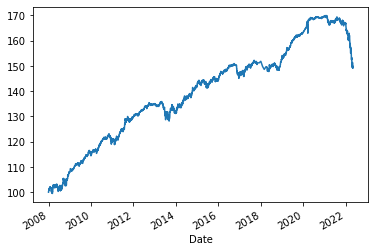

In [104]:
mbs_px.plot()

<AxesSubplot:xlabel='Date'>

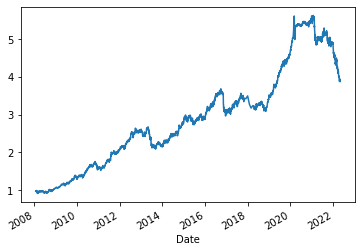

In [112]:
(1+mbs_r_tgt).cumprod().plot()

1.1654433344081025


<AxesSubplot:xlabel='Date'>

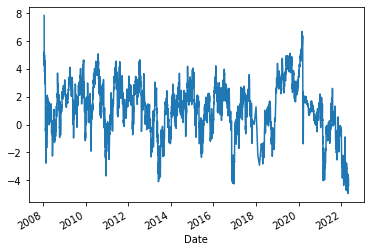

In [103]:
est_sharpe = get_est_sharpe(mbs_r)
print(est_sharpe.mean())
est_sharpe.plot()

1.0557264649098055


<AxesSubplot:xlabel='Date'>

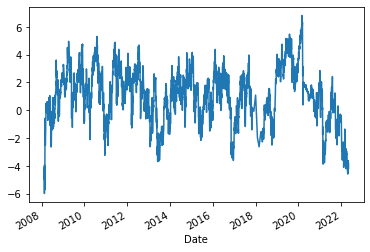

In [113]:
est_sharpe = get_est_sharpe(mbs_r_tgt)
print(est_sharpe.mean())
est_sharpe.plot()